# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

Note:
- Majority of time spent during experimentation right now is spent on building the forest. Meanwhile the queries are actually pretty fast.

In [6]:
import time
import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pytest

from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
from shared.utils import recall, chamfer, timed
from shared.utils import build_multidoc_lsh, build_simple_lsh
from shared.retrieval import best_document, rank_documents
from shared.plotting import plot

sys.path.append(os.path.abspath("../src"))


# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert timed(chamfer, A, B) == pytest.approx(1.0)
assert timed(chamfer, B, A) == pytest.approx(1 + np.sqrt(.5))
assert timed(chamfer, B, C) == pytest.approx(2)
assert timed(chamfer, B, B) == pytest.approx(2)
assert timed(chamfer, C, C) == pytest.approx(4)

chamfer took 0.0001 sec
chamfer took 0.0000 sec
chamfer took 0.0000 sec
chamfer took 0.0000 sec
chamfer took 0.0000 sec


In [7]:
# Hyperparameters and constants
n = 10                                # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 64                                  # dimension per vector
l = 10                                  # trees per forest
k = 5                                  # pivots to keep per node in tree
km = 20                                 # max depth of each tree
a = 10                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)

# Get normalized document and query vectors
data = rng.normal(size=(n, m, d)).astype(np.float32)
data /= np.linalg.norm(data, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

distance = lambda a, b: -np.dot(a, b)


In [8]:
# Baseline

sims = np.array([chamfer(queries, doc_vecs) for doc_vecs in data], dtype=np.float32)
best_doc = int(np.argmax(sims))
best_score = float(sims[best_doc])
print(best_doc, best_score)

true_ranking = np.argsort(-sims)
print(true_ranking[:10])


1 7.72544527053833
[1 8 2 9 7 5 4 0 6 3]


In [ ]:
# Experiment logic

experiments = {
        'l':  list(range(1, 41)),
        'k':  list(range(1, 41)),
        'km': list(range(1, 41)),
        'a':  list(range(1, 41))
}

defaults = dict(l=l, k=k, km=km, a=a)


def nearest_experiment(variable, values, defaults, build):
        sims, docs = [], []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(data, parameters['l'], parameters['k'], parameters['km'], d)
                sim, doc = timed(best_document, forest, queries, distance, parameters['a'])
                sims.append(sim)
                docs.append(doc)
        print(f"Finished nearest experiment: {variable}")
        return sims, docs
    
def recall_experiment(variable, values, defaults, build, num_items):
        recall_vals = []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(data, parameters['l'], parameters['k'], parameters['km'], d)
                ranking = timed(rank_documents, forest, queries, distance, parameters['a'])
                recall_vals.append(recall(true_ranking, ranking, num_items))
        print(f"Finished recall experiment: {variable}")
        return recall_vals
     
    



In [10]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = nearest_experiment(var, vals, defaults, build_simple_lsh)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    

TypeError: best_document() missing 1 required positional argument: 'dist'

best_document took 0.0258 sec
best_document took 0.0318 sec
best_document took 0.0374 sec
best_document took 0.0443 sec
best_document took 0.0483 sec
best_document took 0.0517 sec
best_document took 0.0584 sec
best_document took 0.0658 sec
best_document took 0.0664 sec
best_document took 0.0698 sec
best_document took 0.0762 sec
best_document took 0.0800 sec
best_document took 0.0824 sec
best_document took 0.0835 sec
best_document took 0.1017 sec
best_document took 0.0929 sec
best_document took 0.0943 sec
best_document took 0.0966 sec
best_document took 0.0998 sec
best_document took 0.1019 sec
best_document took 0.1135 sec
best_document took 0.1174 sec
best_document took 0.1283 sec
best_document took 0.1469 sec
best_document took 0.1322 sec
best_document took 0.1397 sec
best_document took 0.1320 sec
best_document took 0.1321 sec
best_document took 0.1341 sec
best_document took 0.1368 sec
best_document took 0.1409 sec
best_document took 0.1486 sec
best_document took 0.1496 sec
best_docum

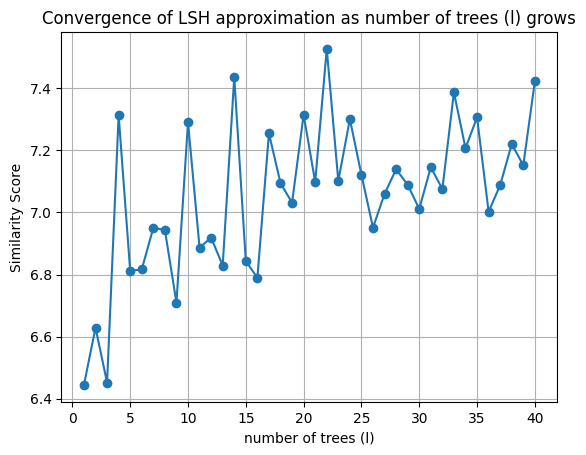

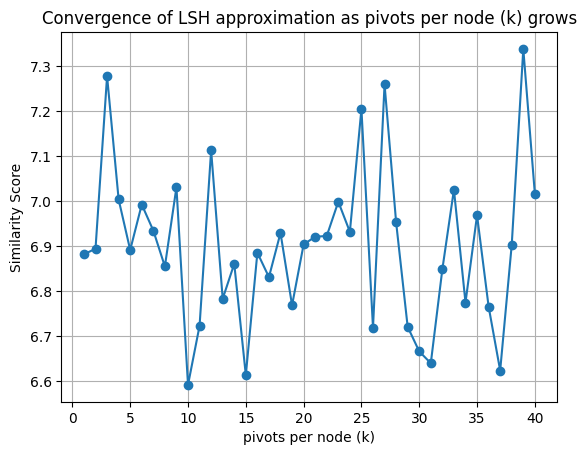

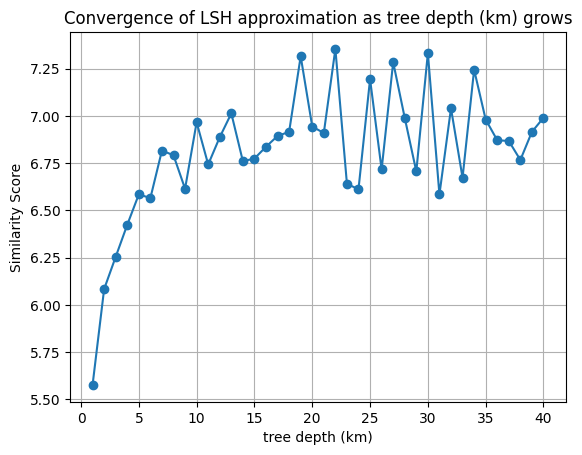

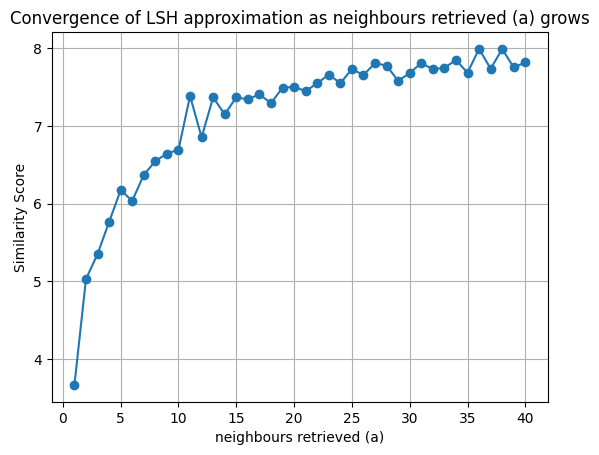

In [ ]:

# Evaluate multi-doc
results = {var: nearest_experiment(var, vals, defaults, build_multidoc_lsh) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')


rank_documents took 0.0272 sec
rank_documents took 0.0344 sec
rank_documents took 0.0419 sec
rank_documents took 0.0468 sec
rank_documents took 0.0513 sec
rank_documents took 0.0556 sec
rank_documents took 0.0613 sec
rank_documents took 0.0647 sec
rank_documents took 0.0699 sec
rank_documents took 0.0733 sec
rank_documents took 0.0756 sec
rank_documents took 0.0816 sec
rank_documents took 0.0842 sec
rank_documents took 0.0870 sec
rank_documents took 0.0926 sec
rank_documents took 0.0949 sec
rank_documents took 0.0987 sec
rank_documents took 0.1034 sec
rank_documents took 0.1088 sec
rank_documents took 0.1110 sec
rank_documents took 0.1163 sec
rank_documents took 0.1165 sec
rank_documents took 0.1240 sec
rank_documents took 0.1247 sec
rank_documents took 0.1288 sec
rank_documents took 0.1320 sec
rank_documents took 0.1382 sec
rank_documents took 0.1417 sec
rank_documents took 0.1435 sec
rank_documents took 0.1444 sec
rank_documents took 0.1484 sec
rank_documents took 0.1511 sec
rank_doc

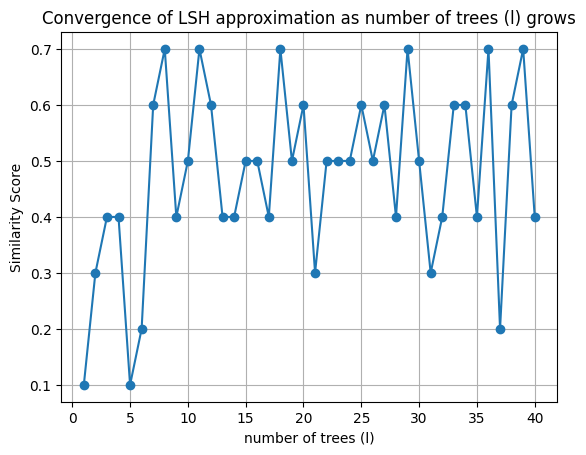

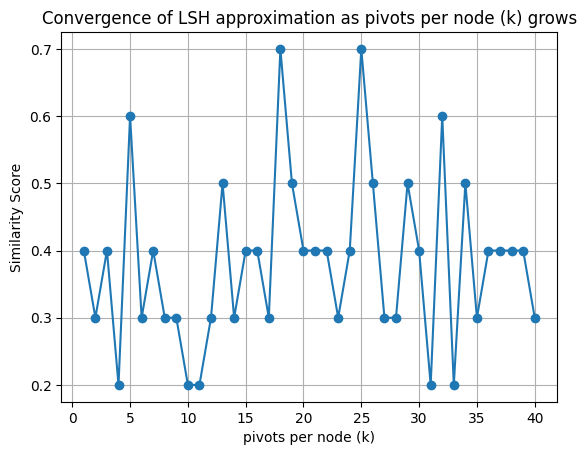

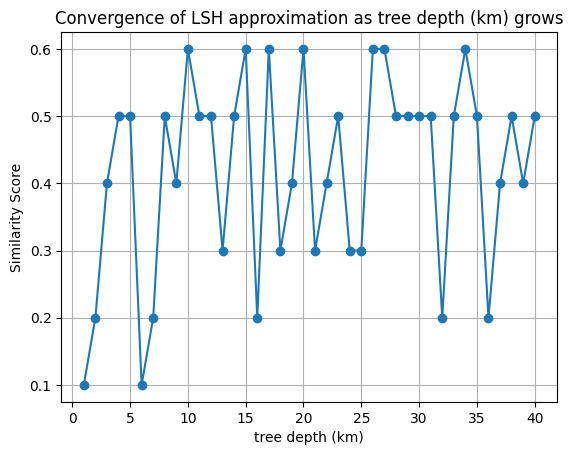

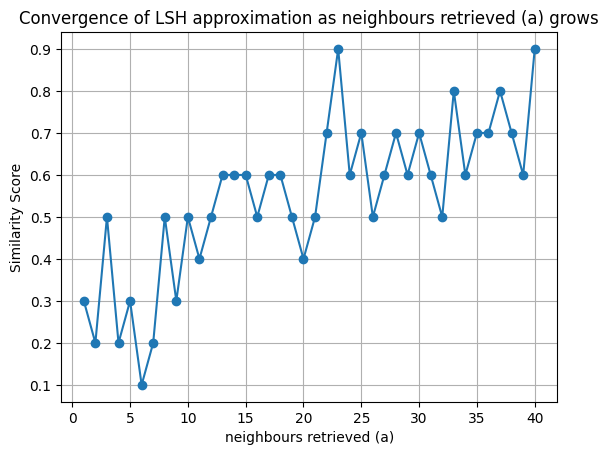

In [ ]:
# Evaluate multi-doc recall
results = {var: recall_experiment(var, vals, defaults, build_multidoc_lsh, 10) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'],  'number of trees (l)')
plot(experiments['k'],  results['k'],  'pivots per node (k)')
plot(experiments['km'], results['km'], 'tree depth (km)')
plot(experiments['a'],  results['a'],  'neighbours retrieved (a)')